<a href="https://colab.research.google.com/github/Coming233/CGAN/blob/main/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Conditional GANs
Reference: https://arxiv.org/pdf/1411.1784.pdf

In [ ]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision
! nvidia-smi

Tue Jan 25 03:42:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/test/utils")
from colab_save_load import m_save_para
save_path = "/content/gdrive/My Drive/Colab Notebooks/test/model/test_save"

In [ ]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [ ]:
def get_sample_image(G,c_value, n_noise=100 ):
    """
        save sample 100 images
    """
    num = 10
    img = np.zeros([28*num, 28*num])
    for j in range(num):
        c = torch.zeros([num, 10]).to(DEVICE)
        c[:,c_value] = 1
        z = torch.randn(num, n_noise).to(DEVICE)
        y_hat = G(z,c).view(num, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
        # print(c[:, j])
    return img

In [ ]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()   #
        v = torch.cat((x, c), 1) # v: [input, label] 这两个元素的一个连接
        y_ = self.layer(v)
        return y_

In [ ]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [ ]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [ ]:
batch_size = 64
condition_size = 10

In [ ]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
max_epoch = 50 # need more than 100 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [ ]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [ ]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)  # 将y的标签作为控制条件。
        y = to_onehot(y).to(DEVICE)     # 进行编码
        x_outputs = D(x, y)             # y就是定义函数里面的控制条件c
        D_x_loss = criterion(x_outputs, D_labels) #先喂真实数据给判别器

        z = torch.randn(batch_size, n_noise).to(DEVICE)   # 然后再喂假数据给判别器
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss  # 所以总共的loss才是判别器的loss        
        
        D.zero_grad() # 梯度下降
        D_loss.backward()
        D_opt.step()
        

        #判别器每训练n_critic就训练一次生成器。

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)  #生成器只需要知道自己的产生的结果能否混淆判别器，即可算loss

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        #if step % 1000 == 0:
           # G.eval()
            #img = get_sample_image(G, n_noise)
            #imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            #G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.3499054908752441, G Loss: 0.692469596862793
Epoch: 0/50, Step: 500, D Loss: 1.3520007133483887, G Loss: 1.0371602773666382
Epoch: 1/50, Step: 1000, D Loss: 1.2869651317596436, G Loss: 1.0301778316497803
Epoch: 1/50, Step: 1500, D Loss: 1.242379903793335, G Loss: 1.362034797668457
Epoch: 2/50, Step: 2000, D Loss: 1.2280762195587158, G Loss: 0.9839338660240173
Epoch: 2/50, Step: 2500, D Loss: 1.2198357582092285, G Loss: 0.9180612564086914
Epoch: 3/50, Step: 3000, D Loss: 1.161870002746582, G Loss: 0.9769788980484009
Epoch: 3/50, Step: 3500, D Loss: 1.1761425733566284, G Loss: 0.8383902311325073
Epoch: 4/50, Step: 4000, D Loss: 1.2016243934631348, G Loss: 1.2897902727127075
Epoch: 4/50, Step: 4500, D Loss: 1.2249972820281982, G Loss: 1.02131187915802
Epoch: 5/50, Step: 5000, D Loss: 1.3391165733337402, G Loss: 0.942317008972168
Epoch: 5/50, Step: 5500, D Loss: 1.2707233428955078, G Loss: 0.6938135623931885
Epoch: 6/50, Step: 6000, D Loss: 1.3809399604797363

## Sample

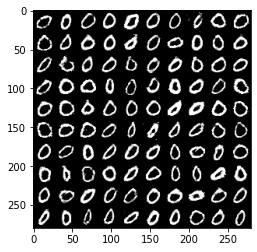

In [ ]:
# 利用生成器生成图像
G.eval()  # 生成器设置为推断（测试）模式
imshow(get_sample_image(G,0, n_noise), cmap='gray')


In [ ]:
#def save_checkpoint(state, file_name='checkpoint.pth.tar'):
 #   torch.save(state, file_name)

In [ ]:
# Saving params.
# save_checkpoint({'epoch': epoch + 1, 'state_dict':D.sate_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_c.pth.tar')tate_dict(), 'optimizer' : D_opt.state_dict()}, 'D_c.pth.tar')
# save_checkpoint({'epoch': epoch + 1, 'st

In [ ]:
# torch.save(D.state_dict(), './model/test_save/D_test.pkl')
# torch.save(G.state_dict(), './model/test_save/G_test.pkl')

In [ ]:
m_save_para(D.state_dict(), save_path, 'D_t.pkl')
m_save_para(G.state_dict(), save_path, 'G_t.pkl')

In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/test/model/test_save'